In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
from torch.utils.data import Dataset, DataLoader
from os import path, listdir
import numpy as np
from scipy import stats as st
import math
import torch
import os
from PIL import Image



device = torch.device("cpu")
if torch.cuda.is_available():
    print("Cuda is available, using it")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("Apple Silicon GPU is available, using it")
    device = torch.device("mps")

Cuda is available, using it


<----------- CREATING AND LOADING DATASET---------------->

In [2]:
# Crops and Pads image to be 190x190 (hides the score)
def process_image(image):
    arr = np.array(image)
    
    trans_arr = np.transpose(arr, ((2,0,1)))
    crop_arr = trans_arr[:, 20:, :160]
    pad_width = ((0, 0), (0, 0), (15, 15))  # Pad 25 columns on each side for each channel
    proc_img = np.pad(crop_arr, pad_width, mode='constant', constant_values=0)
    
    return proc_img

# used when visualizeing the full screen
def process_human_image(image):
    arr = np.array(image)
    trans_arr = np.transpose(arr, ((2,0,1)))
    
    return trans_arr

In [3]:
# Borrowed code to load in the data from the folders
class AtariDataset(Dataset):
    TRAJS_SUBDIR = 'trajectories'
    SCREENS_SUBDIR = 'screens'

    def __init__(self, data_path):
        self.trajs_path = path.join(data_path, AtariDataset.TRAJS_SUBDIR)
        self.screens_path = path.join(data_path, AtariDataset.SCREENS_SUBDIR)
        assert path.exists(self.trajs_path)
        self.trajectories = self.load_trajectories()

        # used to create a mapping of raw_index -> (game_number, screen_number) for DataLoader use
        self.length_to_games = {}
        running_total = 0 
        for k in sorted(self.trajectories['spaceinvaders'].keys()):
            running_total += len(self.trajectories['spaceinvaders'][k])
#             print(k, " : " , len(self.trajectories['spaceinvaders'][k]))
            self.length_to_games[running_total] = k
        
        print("mapping: ",  self.length_to_games)
    def __len__(self):
        return sum([len(atari_dataset.trajectories['spaceinvaders'][k]) for k in atari_dataset.trajectories['spaceinvaders']])

    
    def get_game_and_screen(self, idx):
        """
        Util that allows all images and trajectories to be in range [0...n] where n is the
        sum of all images.
        
        used to create a mapping of raw_index -> (game_number, screen_number)
        """        
        g1 = 0
        for g in self.length_to_games.keys():
            if(idx < g):
                g2 = g
                break
            else:
                g1 = g

        game = self.length_to_games[g2]
        screen_idx = idx - g1
        return game, screen_idx
    
    def __getitem__(self, idx):
        """
        returns the frame number idx for gameplay number GAMEPLAY_NUM
        
        TODO: extend support so it can do multiple gameplays
        """    
        game_num, screen_idx = self.get_game_and_screen(idx)
#         print("idx: ", idx , "game: ", game_num, " screen: ", screen_idx)
        # Load image
        png_path = 'spaceinvaders/' + str(game_num) +  "/" + str(screen_idx) + ".png"
        img_path = os.path.join(self.screens_path, png_path)
        image = Image.open(img_path)
        
        image = process_image(image)

        label = self.trajectories['spaceinvaders'][game_num][screen_idx]['action']
        return image, label


    def load_trajectories(self):
        trajectories = {}
        game = 'spaceinvaders'
        trajectories[game] = {}
        game_dir = path.join(self.trajs_path, game)
        for traj in listdir(game_dir):
            curr_traj = []
            with open(path.join(game_dir, traj)) as f:
                for i, line in enumerate(f):
                    if i > 1:
                        curr_data = line.rstrip('\n').replace(" ", "").split(',')
                        curr_trans = {
                            'frame': int(curr_data[0]),
                            'reward': int(curr_data[1]),
                            'score': int(curr_data[2]),
                            'terminal': int(bool((curr_data[3]))),
                            'action': int(curr_data[4])
                        }
                        curr_traj.append(curr_trans)
            trajectories[game][int(traj.split('.txt')[0])] = curr_traj
        return trajectories

    def compile_data(self, score_lb=0, score_ub=math.inf, max_nb_transitions=None):
        data = []
        shuffled_trajs = np.array(list(self.trajectories['spaceinvaders'].keys()))
        np.random.shuffle(shuffled_trajs)
        for t in shuffled_trajs:
            st_dir = path.join(self.screens_path, str(t))
            cur_traj = self.trajectories['spaceinvaders'][t]
            cur_traj_len = len(listdir(st_dir))
            if not score_lb <= cur_traj[-1]['score'] <= score_ub:
                continue
            for pid in range(0, cur_traj_len):
                state = preprocess(cv2.imread(path.join(st_dir, str(pid) + '.png'), cv2.IMREAD_GRAYSCALE))
                data.append({
                    'action': get_action_name(cur_traj[pid]['action']),
                    'state': state,
                    'reward': cur_traj[pid]['reward'],
                    'terminal': cur_traj[pid]['terminal'] == 1
                })
                if max_nb_transitions and len(data) == max_nb_transitions:
                    return data
        return data


In [4]:
# LOAD IN DATASET FROM FILES
data_path = "high_value_atari_v1"
atari_dataset = AtariDataset(data_path)
# data_loader = DataLoader(atari_dataset, batch_size=64, shuffle=True)
# for batch in data_loader:
#     pass
print(len(atari_dataset))

mapping:  {7587: 46, 18313: 50, 26940: 51, 34490: 71, 44599: 80, 51988: 88, 59311: 107, 69160: 116, 76228: 191, 84198: 195, 95313: 200, 102336: 253, 110770: 292, 117495: 316, 125681: 327, 130331: 339, 137158: 353, 143922: 372, 151077: 392, 158600: 393, 165602: 395, 172084: 399, 180563: 401, 188187: 406, 195213: 407, 201336: 418, 209238: 420, 215638: 423, 223356: 425, 231964: 428, 238803: 432, 249057: 437, 255926: 443, 262587: 447, 271395: 452, 280660: 475, 289295: 476, 297228: 477, 304110: 504, 312067: 507, 318065: 513}
318065


In [36]:
## CREATING DATALOADERS ##
### MAKES TRAINING EASIER ###
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler

# Step 1: Define proportions or sizes for each set
dataset_size = len(atari_dataset)
train_size = int(0.8 * dataset_size)  # 80% for training
val_size = int(0.1 * dataset_size)    # 10% for validation
test_size = int(0.1 * dataset_size)    # 10% for validation

# Step 2: Create indices for each set
indices = list(range(dataset_size))
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Step 3: Create samplers for each set
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

BATCH_SIZE = 16
print("built samplers")
# Step 4: Create DataLoader instances with the respective samplers
train_loader = DataLoader(atari_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
print("train_loader done")
val_loader = DataLoader(atari_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)
print("val_loader done")
test_loader = DataLoader(atari_dataset, batch_size=BATCH_SIZE, sampler=test_sampler)
print("test_loader done")


built samplers
train_loader done
val_loader done
test_loader done


<----------- TRAINING AND BUILDING MODEL ---------------->

In [37]:
### HARDCODED CLASS WEIGHTS FROM SAMPLING USING CODE BELOW ###
weight_counts = {0: 15836, 3: 6483, 4: 5812, 1: 3192, 12: 248, 11: 235}
weight_percents = {0: 0.49, 3: 0.20, 4: 0.18, 1: 0.10, 12: 0.008, 11: 0.008}

## CLASS WEIGHT GENERATION CODE ##
# for _, l in val_loader:
#     l = int(l[0])
#     if l not in weight_counts:
#         weight_counts[l] = 1
#     else:
#         weight_counts[l] += 1
# weight_percents = {}
# total = sum([weight_counts[k] for k in weight_counts])
# for k in weight_counts:
#     weight_percents[k] = weight_counts[k] / total
    

In [38]:
# These are the actual class weights that are being used #
estimated_weights = [0.4,1.1,1,2,2,1,1,1,1,1,1,1,1,1,1,1]
estimated_weights = torch.tensor(estimated_weights).to(device, dtype=torch.float32)

In [ ]:
### MAIN TRAINING LOOP ###
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import tqdm

# Assuming you have defined your model, loss function, optimizer, and data loaders
model = models.VisionTransformer(
            num_classes=16,
            image_size=190,
            patch_size= 5, # idk it was a guess 
            num_layers= 2,
            num_heads= 2,
            hidden_dim= 50,
            mlp_dim=10,
            dropout=0.01,
            attention_dropout=0.01,
).to(device)

# Define your model, loss function, and optimizer
criterion = nn.CrossEntropyLoss(weight=estimated_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50

load_checkpoint = False

if (load_checkpoint):
    checkpoint_path = 'cropped_full_from_none_vt_ecoch_21.pth'
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_loss = checkpoint['train_loss']
    train_accuracy = checkpoint['train_accuracy']
    val_loss = checkpoint['val_loss']
    val_accuracy = checkpoint['val_accuracy']
    print("checkpoint loaded")
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device=device, dtype=torch.float32), labels.to(device=device, dtype=torch.int64)
        
        optimizer.zero_grad()

#         print(inputs.shape, type(inputs))

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / total_samples

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.int64)

            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = correct_predictions / total_samples

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
    
    checkpoint_path = f'mini20_move_weights_ecoch_{epoch+1}.pth'
    torch.save({
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    }, checkpoint_path)

# After training, you can evaluate on the test set similarly


Epoch 1/50: 100%|██████████| 3976/3976 [05:48<00:00, 11.41it/s]


Epoch [1/50], Train Loss: 1.5096, Train Acc: 0.1778, Val Loss: 1.4442, Val Acc: 0.1985


Epoch 2/50: 100%|██████████| 3976/3976 [05:49<00:00, 11.39it/s]


Epoch [2/50], Train Loss: 1.4889, Train Acc: 0.1955, Val Loss: 1.4320, Val Acc: 0.2122


Epoch 3/50: 100%|██████████| 3976/3976 [05:47<00:00, 11.43it/s]


Epoch [3/50], Train Loss: 1.4694, Train Acc: 0.2189, Val Loss: 1.4438, Val Acc: 0.2225


Epoch 4/50: 100%|██████████| 3976/3976 [05:47<00:00, 11.43it/s]


Epoch [4/50], Train Loss: 1.4594, Train Acc: 0.2284, Val Loss: 1.4468, Val Acc: 0.2130


Epoch 5/50: 100%|██████████| 3976/3976 [05:48<00:00, 11.42it/s]


Epoch [5/50], Train Loss: 1.4487, Train Acc: 0.2362, Val Loss: 1.4855, Val Acc: 0.2097


Epoch 6/50: 100%|██████████| 3976/3976 [05:47<00:00, 11.43it/s]


Epoch [6/50], Train Loss: 1.4354, Train Acc: 0.2515, Val Loss: 1.4842, Val Acc: 0.2061


Epoch 7/50:  47%|████▋     | 1875/3976 [02:44<03:01, 11.57it/s]

In [ ]:
logits = model(inputs)
arr = np.array(logits.cpu().detach().numpy())

In [ ]:
### THIS CODE GETS LOSS INFORMATION FROM CHECKPOINTS IF IT WAS FORGOTTON ###
# ONLY NEEDED WHEN GENERATING LOSS CHARTS #
print("ALL CHECKPOINT SCORES")
for run in range(1, 22):
    checkpoint_path = f'cropped_full_from_none_vt_ecoch_{run}.pth'
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_loss = checkpoint['train_loss']
    train_accuracy = checkpoint['train_accuracy']
    val_loss = checkpoint['val_loss']
    val_accuracy = checkpoint['val_accuracy']
    print("checkpoint loaded")
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')


In [9]:
# PUT MODEL YOU WANT TO USE HERE
checkpoint_path = 'extened_cropped_full_from_none_vt_ecoch_3.pth'

checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
train_accuracy = checkpoint['train_accuracy']
val_loss = checkpoint['val_loss']
val_accuracy = checkpoint['val_accuracy']
print("checkpoint loaded")
print(f'Epoch [{epoch+1}/{num_epochs}], '
      f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
      f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

checkpoint loaded
Epoch [4/50], Train Loss: 1.4321, Train Acc: 0.3583, Val Loss: 1.4295, Val Acc: 0.2969


In [10]:
# see a sample of what chosen actions look like
logits = model(inputs)
arr = np.array(logits.cpu().detach().numpy())
np.argmax(arr, axis=1)

array([0, 1, 3, 0, 3, 1, 3, 1, 3, 0, 4, 4, 1, 1, 0, 3])

In [ ]:
## Visualize the network playing ##
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import re
import copy
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
env = gym.make("SpaceInvaders-v0")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


import time
from skimage.color import rgb2gray
from skimage.transform import rescale
import numpy as np
num_frames=4
render=False
see_what_agent_sees=True

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

all_actions = []
all_rewards = []
final_states = []
human_state_chain = []  # used to backtrace the states later

state = None
early_stop = False
print("episode: ")
for i_episode in range(num_episodes):
    # used for backtracing good runs for gif generation  
    if(early_stop):
        print("Stopped early for good run GIF generation")
        break
        
    # Initialize the environment and get its state
    state, info = env.reset()
    human_state = np.transpose(process_human_image(state), (1, 2, 0))
    state = process_image(state)    
#     print(state.shape)
    # show image for funs
#     plt.imshow(human_state)
    print(i_episode, end='\r')
    episode_reward = 0
    if render:
        if see_what_agent_sees:
            img = plt.imshow(human_state)
        else:
            img = plt.imshow(env.render())
    for t in count():
        if render and t%10==0:
            if see_what_agent_sees:
                img = plt.imshow(human_state)
            else:
                img = plt.imshow(env.render())
            display.display(plt.gcf())
            display.clear_output(wait=True)
        
                        
#         print("getting action")
        state = np.expand_dims(state, axis=0)
#         print(state.shape)
        state = torch.tensor(state, device=device, dtype=torch.float32)
        logits = model(state)
        action = torch.argmax(logits)
        action_val = action.item()
        all_actions.append(action.item())
        
        # Only allow valid actions
        # The model has witnessed some actions like 11 and 12 that we ignore         
        if action_val not in [0,1,3,4]:
            action_val = 0
            
        # create new states         
        observation, reward, terminated, truncated, _ = env.step(action_val)
        human_state = np.transpose(process_human_image(observation), (1, 2, 0))
        human_state_chain.append(human_state)
        
        episode_reward += reward
        state = process_image(observation)    
        
        
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            all_rewards.append(episode_reward)
            # Used to backtrace trials that did very well
            if(episode_reward > 500):
                early_stop = True
                break
            human_state_chain = []
            final_states.append(human_state)
            state = None

        if done:
#             episode_durations.append(t + 1)
#             plot_durations()
#             print("done")
            break
        
print('Complete')
# plot_durations(show_result=True, render=False)
plt.ioff()
plt.show()

[0 1 3 4] [1016 1986  263   19]


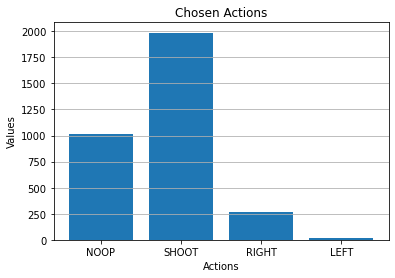

[0 1 3 4] [1016 1986  263   19]


In [32]:
## Get charts showing which actions are used most for most recent run ##
unique_numbers, counts = np.unique(all_actions, return_counts=True)

if(len(counts) != 4):
    counts = list(counts)
    counts.append(0)
print(unique_numbers, counts)

import matplotlib.pyplot as plt

# Given data
actions = ['NOOP', 'SHOOT', 'RIGHT', 'LEFT']
values = counts

# Plotting
plt.bar(actions, values)
plt.xlabel('Actions')
plt.ylabel('Values')
plt.title('Chosen Actions')
plt.grid(axis='y')   # Show grid lines only along the y-axis
plt.show()

print(unique_numbers, counts)

In [166]:
# Generate 'movie' of most recent run #
import time
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

print("number of frames: ", len(human_state_chain))
human_state_chain = human_state_chain[::-1]
for frame in human_state_chain:
    img = plt.imshow(frame)
    display.display(plt.gcf())
    display.clear_output(wait=True)

plt.ioff()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f67eba9d940> (for post_execute):


KeyboardInterrupt: 

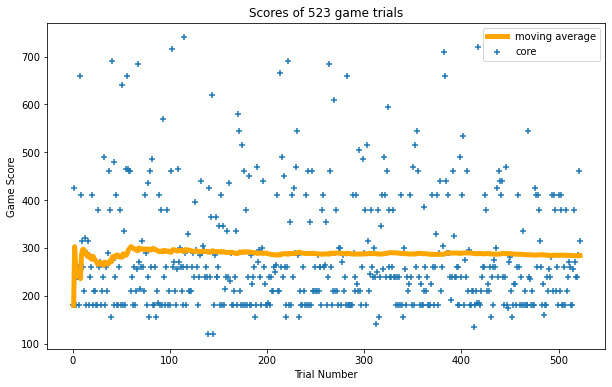

In [168]:
# plot each trial score and moving average of them
import matplotlib.pyplot as plt

moving_avg = [np.average(all_rewards[:i]) for i,v in enumerate(all_rewards)]


scatter_scores_x = [i for i, v in enumerate(all_rewards)]
scatter_scores_y = [v for i, v in enumerate(all_rewards)]

plt.figure(figsize=(10, 6))  # Larger plot size

plt.plot(moving_avg, linewidth=5, color="orange", label="moving average")
plt.scatter(scatter_scores_x,scatter_scores_y, marker='+',label="core")

plt.legend()
plt.xlabel('Trial Number')
plt.ylabel('Game Score')

plt.title(f'Scores of {len(moving_avg)} game trials')
plt.savefig('Vision-Transformer-scores_with_avg')
plt.show()


TypeError: Invalid shape (3, 210, 160) for image data

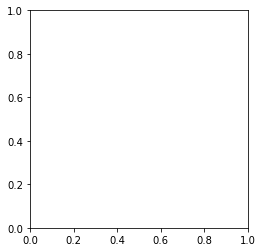

In [24]:
### GET AVERAGE SCORES ####

In [ ]:
# ALL REWARDS FROM A TRIAL OF 523 RUNS #
# Keeping so that I do not have to rerun 523 tests for full model epoch 21
# all_rewards = [180.0, 425.0, 180.0, 180.0, 240.0, 240.0, 260.0, 180.0, 660.0, 410.0, 315.0, 260.0, 210.0, 320.0, 180.0, 290.0, 315.0, 180.0, 240.0, 260.0, 410.0, 180.0, 210.0, 210.0, 180.0, 180.0, 380.0, 260.0, 270.0, 180.0, 210.0, 240.0, 490.0, 180.0, 260.0, 210.0, 290.0, 460.0, 380.0, 155.0, 690.0, 275.0, 180.0, 480.0, 240.0, 410.0, 180.0, 180.0, 260.0, 380.0, 180.0, 640.0, 180.0, 335.0, 180.0, 465.0, 660.0, 465.0, 460.0, 460.0, 210.0, 240.0, 180.0, 260.0, 180.0, 210.0, 255.0, 685.0, 270.0, 215.0, 260.0, 315.0, 260.0, 210.0, 410.0, 290.0, 180.0, 435.0, 240.0, 155.0, 460.0, 260.0, 485.0, 180.0, 180.0, 260.0, 155.0, 210.0, 185.0, 410.0, 180.0, 380.0, 180.0, 570.0, 240.0, 180.0, 260.0, 380.0, 180.0, 210.0, 180.0, 460.0, 715.0, 260.0, 270.0, 210.0, 180.0, 255.0, 465.0, 270.0, 300.0, 260.0, 210.0, 180.0, 260.0, 740.0, 290.0, 180.0, 260.0, 330.0, 210.0, 210.0, 210.0, 260.0, 290.0, 240.0, 395.0, 295.0, 260.0, 180.0, 240.0, 285.0, 440.0, 290.0, 305.0, 295.0, 240.0, 260.0, 240.0, 120.0, 425.0, 240.0, 365.0, 620.0, 120.0, 180.0, 285.0, 365.0, 240.0, 240.0, 260.0, 345.0, 180.0, 410.0, 180.0, 345.0, 180.0, 215.0, 240.0, 335.0, 240.0, 435.0, 230.0, 290.0, 180.0, 180.0, 210.0, 240.0, 335.0, 180.0, 580.0, 545.0, 210.0, 180.0, 515.0, 180.0, 460.0, 180.0, 380.0, 180.0, 240.0, 450.0, 180.0, 180.0, 285.0, 225.0, 240.0, 260.0, 155.0, 180.0, 470.0, 270.0, 295.0, 240.0, 180.0, 300.0, 440.0, 260.0, 225.0, 180.0, 180.0, 185.0, 240.0, 180.0, 240.0, 210.0, 210.0, 260.0, 250.0, 265.0, 410.0, 210.0, 210.0, 665.0, 260.0, 490.0, 240.0, 450.0, 260.0, 155.0, 180.0, 260.0, 690.0, 180.0, 355.0, 180.0, 410.0, 240.0, 425.0, 290.0, 470.0, 545.0, 285.0, 155.0, 210.0, 180.0, 180.0, 260.0, 210.0, 180.0, 410.0, 180.0, 460.0, 180.0, 355.0, 180.0, 460.0, 210.0, 210.0, 260.0, 210.0, 210.0, 285.0, 210.0, 260.0, 260.0, 180.0, 380.0, 410.0, 260.0, 265.0, 355.0, 180.0, 240.0, 685.0, 460.0, 260.0, 180.0, 210.0, 610.0, 210.0, 380.0, 210.0, 180.0, 300.0, 300.0, 180.0, 270.0, 285.0, 210.0, 240.0, 180.0, 660.0, 180.0, 180.0, 180.0, 180.0, 180.0, 410.0, 290.0, 240.0, 210.0, 410.0, 225.0, 210.0, 505.0, 210.0, 180.0, 260.0, 485.0, 290.0, 380.0, 180.0, 515.0, 315.0, 210.0, 245.0, 380.0, 260.0, 240.0, 300.0, 240.0, 140.0, 250.0, 380.0, 155.0, 240.0, 345.0, 410.0, 255.0, 490.0, 410.0, 240.0, 460.0, 595.0, 260.0, 380.0, 240.0, 240.0, 260.0, 380.0, 240.0, 240.0, 180.0, 240.0, 180.0, 240.0, 180.0, 410.0, 180.0, 155.0, 300.0, 255.0, 180.0, 240.0, 210.0, 225.0, 410.0, 240.0, 180.0, 470.0, 180.0, 515.0, 260.0, 545.0, 460.0, 240.0, 180.0, 225.0, 180.0, 180.0, 385.0, 210.0, 260.0, 210.0, 240.0, 180.0, 180.0, 180.0, 225.0, 410.0, 260.0, 180.0, 260.0, 330.0, 410.0, 180.0, 290.0, 440.0, 210.0, 260.0, 305.0, 710.0, 660.0, 440.0, 290.0, 410.0, 290.0, 240.0, 190.0, 240.0, 460.0, 325.0, 240.0, 240.0, 260.0, 180.0, 260.0, 180.0, 490.0, 240.0, 410.0, 535.0, 180.0, 275.0, 240.0, 460.0, 210.0, 295.0, 180.0, 180.0, 210.0, 210.0, 135.0, 180.0, 210.0, 185.0, 720.0, 185.0, 180.0, 210.0, 240.0, 260.0, 260.0, 410.0, 380.0, 210.0, 225.0, 210.0, 260.0, 155.0, 240.0, 260.0, 180.0, 275.0, 260.0, 300.0, 425.0, 240.0, 460.0, 440.0, 410.0, 440.0, 240.0, 180.0, 240.0, 470.0, 180.0, 175.0, 270.0, 280.0, 210.0, 155.0, 180.0, 225.0, 225.0, 180.0, 260.0, 410.0, 260.0, 180.0, 240.0, 180.0, 335.0, 180.0, 210.0, 180.0, 180.0, 180.0, 545.0, 240.0, 235.0, 180.0, 210.0, 180.0, 180.0, 425.0, 410.0, 260.0, 410.0, 380.0, 315.0, 260.0, 180.0, 225.0, 160.0, 180.0, 180.0, 240.0, 210.0, 255.0, 240.0, 280.0, 410.0, 210.0, 410.0, 380.0, 210.0, 260.0, 180.0, 410.0, 210.0, 380.0, 410.0, 180.0, 180.0, 260.0, 180.0, 380.0, 210.0, 240.0, 270.0, 260.0, 180.0, 180.0, 255.0, 380.0, 270.0, 240.0, 240.0, 285.0, 460.0, 315.0]